## Prerequisite

Make sure you ran `snakemake` in this directory and have obtained all the files (stored under `output/`).

### Load original clinvar variants

In [1]:
import kipoi_veff

In [2]:
df_clinvar = pd.DataFrame(list(kipoi_veff.parsers.KipoiVCFParser("input/clinvar_20180429.enhancer-regions.chr22.vcf.gz")))

In [3]:
df_clinvar.head()

,variant_id,variant_chr,variant_pos,variant_ref,variant_alt,other_AF_ESP,other_AF_EXAC,other_AF_TGP,other_ALLELEID,other_CLNDN,other_CLNDNINCL,other_CLNDISDB,other_CLNDISDBINCL,other_CLNHGVS,other_CLNREVSTAT,other_CLNSIG,other_CLNSIGCONF,other_CLNSIGINCL,other_CLNVC,other_CLNVCSO,other_CLNVI,other_DBVARID,other_GENEINFO,other_MC,other_ORIGIN,other_RS,other_SSR
0,120305,chr22,17684454,G,A,1.0000e-04,3.0000e-05,0.0002,125899,"Polyarteritis_nodosa,...",None,"MedGen:C3887654,OMIM:...",None,NC_000022.10:g.176844...,no_assertion_criteria...,Pathogenic,None,None,single_nucleotide_var...,SO:0001483,OMIM_Allelic_Variant:...,None,ADA2:51816,SO:0001583|missense_v...,1,148936893,NaN
1,375251,chr22,17684466,G,A,NaN,3.0000e-05,NaN,361952,Behcet's_syndrome,None,"MedGen:C0004943,OMIM:...",None,NC_000022.10:g.176844...,no_assertion_criteria...,Pathogenic,None,None,single_nucleotide_var...,SO:0001483,None,None,ADA2:51816,SO:0001583|missense_v...,1,750868279,NaN
2,421491,chr22,17684643,A,G,NaN,NaN,NaN,410909,not_specified,None,MedGen:CN169374,None,NC_000022.10:g.176846...,"criteria_provided,_si...",Uncertain_significance,None,None,single_nucleotide_var...,SO:0001483,None,None,ADA2:51816,SO:0001583|missense_v...,1,760102576,NaN
3,195349,chr22,18604282,G,T,NaN,NaN,NaN,192510,not_specified,None,MedGen:CN169374,None,NC_000022.10:g.186042...,"criteria_provided,_si...",Uncertain_significance,None,None,single_nucleotide_var...,SO:0001483,None,None,TUBA8:51807,SO:0001583|missense_v...,1,794727300,NaN
4,127267,chr22,18900750,G,A,NaN,NaN,NaN,132724,not_provided,None,MedGen:CN517202,None,NC_000022.10:g.189007...,no_assertion_criteria...,Uncertain_significance,None,None,single_nucleotide_var...,SO:0001483,None,None,PRODH:5625,SO:0001819|synonymous...,4,372055,1.0


In [41]:
ls -latr input/

total 52680
-rw-rw-r-- 1 avsec avsec    42653 Nov  7 20:08 20180429.filtered.top1k.vcf.gz
-rw-rw-r-- 1 avsec avsec 50818476 Nov  7 20:08 hg38_chr22.fa
-rw-rw-r-- 1 avsec avsec      209 Nov  7 20:08 variants.vcf.gz
-rw-rw-r-- 1 avsec avsec  2716399 Nov  7 20:08 20180429.filtered.vcf.gz
-rw-rw-r-- 1 avsec avsec       35 Nov  7 21:53 hg38_chr22.fa.fai
-rw-rw-r-- 1 avsec avsec   207042 Nov  9 14:44 clinvar_20180429.chr22.vcf.gz
-rw-rw-r-- 1 avsec avsec     8795 Nov  9 15:28 clinvar_20180429.enhancer-regions.chr22.vcf.gz
drwxrwxr-x 2 avsec avsec     4096 Nov  9 15:31 ./
-rw-rw-r-- 1 avsec avsec     8929 Nov  9 15:58 clinvar_20180429.enhancer-regions.chr22.vcf.gz.gz
-rw-rw-r-- 1 avsec avsec      599 Nov  9 15:58 clinvar_20180429.enhancer-regions.chr22.vcf.gz.gz.tbi
-rw-rw-r-- 1 avsec avsec      209 Nov  9 15:59 variants.vcf.gz.gz
-rw-rw-r-- 1 avsec avsec      204 Nov  9 15:59 variants.vcf.gz.gz.tbi
drwxrwxr-x 8 avsec avsec     4096 Nov  9 16:15 ../


## Load and visualize the predictions

In [5]:
import kipoi
import pandas as pd
import snakemake

# Get all models and interval_sets for which we computed the predictions
models, vcf_sets = list(zip(*list(zip(*snakemake.utils.listfiles("output/{model}/{interval_set}.tsv")))[1]))
models = kipoi.utils.unique_list(models)
vcf_sets = kipoi.utils.unique_list(vcf_sets)

### Loading predictions from the tsv output

In [6]:
import kipoi
import seaborn as sns
import pandas as pd

In [12]:
variant_cols = ['variant_chr', 'variant_pos', 'variant_ref', 'variant_alt']

In [13]:
merge_cols = variant_cols + ['variant_id', 'line_idx', 'vcf_set']

In [14]:
def read_preds_tsv(model, vcf_set, output_dir):
    df = pd.read_table("{}/{}/{}.tsv".format(output_dir, model, vcf_set))
    df['vcf_set'] = vcf_set
    df.set_index(merge_cols, inplace=True)
    assert df.columns.str.startswith("preds").all()
    
    # TODO - update
    
    df.columns = df.columns.str.replace("preds", model)
    
    if len(df.columns) > 1:
        # multi-task model
        try:
            descr = kipoi.get_model_descr(model)
            df.columns = model + "/" + pd.Series(descr.schema.targets.column_labels)
        except:
            pass
    return df

In [27]:
df = pd.concat([pd.concat([read_preds_tsv(m, vcf_set=vcf_set, output_dir='output') for vcf_set in vcf_sets], axis=0) for m in models], axis=1)

In [28]:
df.head()

DeepSEA/variantEffects/alt/8988T_DNase_None  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                                                                  
chr22       17684454    G           A           120305     chr22:17684454:G:['A'] clinvar_20180429.enhan...                    0.0105                      
            17684466    G           A           375251     chr22:17684466:G:['A'] clinvar_20180429.enhan...                    0.0135                      
            17684643    A           G           421491     chr22:17684643:A:['G'] clinvar_20180429.enhan...                    0.0021                      
            18604282    G           T           195349     chr22:18604282:G:['T'] clinvar_20180429.enhan...                    0.0033                      
            18900750    G           A           127267     chr22:18900750:G:['A'] clinvar_20180429.enhan...                    0.0394                      

                                                                                                             DeepSEA/variantEffects/alt/A549_ATF3_EtOH_0.02pct  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                                                                        
chr22       17684454    G           A           120305     chr22:17684454:G:['A'] clinvar_20180429.enhan...                1.4644e-04                            
            17684466    G           A           375251     chr22:17684466:G:['A'] clinvar_20180429.enhan...                1.4261e-04                            
            17684643    A           G           421491     chr22:17684643:A:['G'] clinvar_20180429.enhan...                2.8660e-04                            
            18604282    G           T           195349     chr22:18604282:G:['T'] clinvar_20180429.enhan...                1.9522e-04                            
            18900750    G           A           127267     chr22:18900750:G:['A'] clinvar_20180429.enhan...                7.1051e-05                            

                                                                                                             DeepSEA/variantEffects/alt/A549_BCL3_EtOH_0.02pct  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                                                                        
chr22       17684454    G           A           120305     chr22:17684454:G:['A'] clinvar_20180429.enhan...                    0.0005                            
            17684466    G           A           375251     chr22:17684466:G:['A'] clinvar_20180429.enhan...                    0.0005                            
            17684643    A           G           421491     chr22:17684643:A:['G'] clinvar_20180429.enhan...                    0.0008                            
            18604282    G           T           195349     chr22:18604282:G:['T'] clinvar_20180429.enhan...                    0.0009                            
            18900750    G           A           127267     chr22:18900750:G:['A'] clinvar_20180429.enhan...                    0.0003                            

                                                                                                             DeepSEA/variantEffects/alt/A549_BHLHE40_None  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                                                                   
chr22       17684454    G           A           120305     chr22:17684454:G:['A'] clinvar_20180429.enhan...                5.9902e-05                       
            17684466    G           A           375251     chr22:17684466:G:['A'] clinvar_20180429.enhan...                6.1239e-05                       
            17684643    A           G           421491     chr22:17684643:A:['G'] clinvar_20180429.enhan...           

In [35]:
df_clinvar[variant_cols + ['other_CLNSIG']]

,variant_chr,variant_pos,variant_ref,variant_alt,other_CLNSIG
0,chr22,17684454,G,A,Pathogenic
1,chr22,17684466,G,A,Pathogenic
2,chr22,17684643,A,G,Uncertain_significance
...,...,...,...,...,...
139,chr22,50658053,A,G,Benign
140,chr22,50658165,G,A,Benign
141,chr22,50658424,T,C,Benign


In [52]:
dfm = pd.merge(df.reset_index(), df_clinvar[variant_cols + ['other_CLNSIG']], on=variant_cols, how='left')
dfm.head()

,variant_chr,variant_pos,variant_ref,variant_alt,variant_id,line_idx,vcf_set,DeepSEA/variantEffects/alt/8988T_DNase_None,DeepSEA/variantEffects/alt/A549_ATF3_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_BCL3_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_BHLHE40_None,DeepSEA/variantEffects/alt/A549_CEBPB_None,DeepSEA/variantEffects/alt/A549_CREB1_DEX_100nM,DeepSEA/variantEffects/alt/A549_CTCF_DEX_100nM,DeepSEA/variantEffects/alt/A549_CTCF_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_CTCF_None/0,DeepSEA/variantEffects/alt/A549_CTCF_None/1,DeepSEA/variantEffects/alt/A549_DNase_None,DeepSEA/variantEffects/alt/A549_ELF1_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_ETS1_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_FOSL2_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_FOXA1_DEX_100nM,DeepSEA/variantEffects/alt/A549_GABP_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_GR_DEX_100nM,DeepSEA/variantEffects/alt/A549_GR_DEX_500pM,DeepSEA/variantEffects/alt/A549_GR_DEX_50nM,DeepSEA/variantEffects/alt/A549_GR_DEX_5nM,DeepSEA/variantEffects/alt/A549_Max_None,DeepSEA/variantEffects/alt/A549_NRSF_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_Pol2(phosphoS2)_None,DeepSEA/variantEffects/alt/A549_Pol2_DEX_100nM,DeepSEA/variantEffects/alt/A549_Pol2_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_Pol2_None,DeepSEA/variantEffects/alt/A549_Rad21_None,DeepSEA/variantEffects/alt/A549_SIX5_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_Sin3Ak-20_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_TAF1_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_TCF12_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_USF-1_DEX_100nM,DeepSEA/variantEffects/alt/A549_USF-1_EtOH_0.02pct/0,DeepSEA/variantEffects/alt/A549_USF-1_EtOH_0.02pct/1,DeepSEA/variantEffects/alt/A549_YY1_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_ZBTB33_EtOH_0.02pct,DeepSEA/variantEffects/alt/A549_p300_EtOH_0.02pct,DeepSEA/variantEffects/alt/AG04449_CTCF_None,DeepSEA/variantEffects/alt/AG04449_DNase_None,DeepSEA/variantEffects/alt/AG04450_CTCF_None,DeepSEA/variantEffects/alt/AG04450_DNase_None,DeepSEA/variantEffects/alt/AG09309_CTCF_None,DeepSEA/variantEffects/alt/AG09309_DNase_None,DeepSEA/variantEffects/alt/AG09319_CTCF_None,DeepSEA/variantEffects/alt/AG09319_DNase_None,DeepSEA/variantEffects/alt/AG10803_CTCF_None,DeepSEA/variantEffects/alt/AG10803_DNase_None,DeepSEA/variantEffects/alt/Adult_CD4_Th0_DNase_None,DeepSEA/variantEffects/alt/AoAF_CTCF_None,DeepSEA/variantEffects/alt/AoAF_DNase_None,DeepSEA/variantEffects/alt/AoSMC_DNase_None,DeepSEA/variantEffects/alt/BE2_C_CTCF_None,DeepSEA/variantEffects/alt/BE2_C_DNase_None,DeepSEA/variantEffects/alt/BJ_CTCF_None,DeepSEA/variantEffects/alt/BJ_DNase_None,DeepSEA/variantEffects/alt/CD20+_DNase_None,DeepSEA/variantEffects/alt/CD34+_Mobilized_DNase_None,DeepSEA/variantEffects/alt/CLL_DNase_None,DeepSEA/variantEffects/alt/CMK_DNase_None,DeepSEA/variantEffects/alt/Caco-2_CTCF_None,DeepSEA/variantEffects/alt/Caco-2_DNase_None,DeepSEA/variantEffects/alt/Chorion_DNase_None,DeepSEA/variantEffects/alt/Dnd41_CTCF_None,DeepSEA/variantEffects/alt/Dnd41_EZH2_None,DeepSEA/variantEffects/alt/ECC-1_CTCF_DMSO_0.02pct,DeepSEA/variantEffects/alt/ECC-1_ERalpha_BPA_100nM,DeepSEA/variantEffects/alt/ECC-1_ERalpha_Estradiol_10nM,DeepSEA/variantEffects/alt/ECC-1_ERalpha_Genistein_100nM,DeepSEA/variantEffects/alt/ECC-1_FOXA1_DMSO_0.02pct,DeepSEA/variantEffects/alt/ECC-1_GR_DEX_100nM,DeepSEA/variantEffects/alt/ECC-1_Pol2_DMSO_0.02pct,DeepSEA/variantEffects/alt/FibroP_DNase_None,DeepSEA/variantEffects/alt/Fibrobl_CTCF_None,DeepSEA/variantEffects/alt/Fibrobl_DNase_None,DeepSEA/variantEffects/alt/GM06990_CTCF_None,DeepSEA/variantEffects/alt/GM06990_DNase_None,DeepSEA/variantEffects/alt/GM08714_ZNF274_None,DeepSEA/variantEffects/alt/GM10847_NFKB_TNFa,DeepSEA/variantEffects/alt/GM10847_Pol2_None,DeepSEA/variantEffects/alt/GM12801_CTCF_None,DeepSEA/variantEffects/alt/GM12864_CTCF_None,DeepSEA/variantEffects/alt/GM12864_DNase_None,DeepSEA/variantEffects/alt/GM12865_CTCF_None,DeepSEA/variantEffects/alt/GM12865_D

In [58]:
idx_values = ['vcf_set', 'other_CLNSIG']

In [59]:
dfm_sub = dfm[idx_values + dfm.columns[dfm.columns.str.match('.*/diff/.*')].tolist()]
dfm_sub

,vcf_set,other_CLNSIG,DeepSEA/variantEffects/diff/8988T_DNase_None,DeepSEA/variantEffects/diff/A549_ATF3_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_BCL3_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_BHLHE40_None,DeepSEA/variantEffects/diff/A549_CEBPB_None,DeepSEA/variantEffects/diff/A549_CREB1_DEX_100nM,DeepSEA/variantEffects/diff/A549_CTCF_DEX_100nM,DeepSEA/variantEffects/diff/A549_CTCF_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_CTCF_None/0,DeepSEA/variantEffects/diff/A549_CTCF_None/1,DeepSEA/variantEffects/diff/A549_DNase_None,DeepSEA/variantEffects/diff/A549_ELF1_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_ETS1_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_FOSL2_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_FOXA1_DEX_100nM,DeepSEA/variantEffects/diff/A549_GABP_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_GR_DEX_100nM,DeepSEA/variantEffects/diff/A549_GR_DEX_500pM,DeepSEA/variantEffects/diff/A549_GR_DEX_50nM,DeepSEA/variantEffects/diff/A549_GR_DEX_5nM,DeepSEA/variantEffects/diff/A549_Max_None,DeepSEA/variantEffects/diff/A549_NRSF_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_Pol2(phosphoS2)_None,DeepSEA/variantEffects/diff/A549_Pol2_DEX_100nM,DeepSEA/variantEffects/diff/A549_Pol2_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_Pol2_None,DeepSEA/variantEffects/diff/A549_Rad21_None,DeepSEA/variantEffects/diff/A549_SIX5_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_Sin3Ak-20_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_TAF1_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_TCF12_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_USF-1_DEX_100nM,DeepSEA/variantEffects/diff/A549_USF-1_EtOH_0.02pct/0,DeepSEA/variantEffects/diff/A549_USF-1_EtOH_0.02pct/1,DeepSEA/variantEffects/diff/A549_YY1_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_ZBTB33_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_p300_EtOH_0.02pct,DeepSEA/variantEffects/diff/AG04449_CTCF_None,DeepSEA/variantEffects/diff/AG04449_DNase_None,DeepSEA/variantEffects/diff/AG04450_CTCF_None,DeepSEA/variantEffects/diff/AG04450_DNase_None,DeepSEA/variantEffects/diff/AG09309_CTCF_None,DeepSEA/variantEffects/diff/AG09309_DNase_None,DeepSEA/variantEffects/diff/AG09319_CTCF_None,DeepSEA/variantEffects/diff/AG09319_DNase_None,DeepSEA/variantEffects/diff/AG10803_CTCF_None,DeepSEA/variantEffects/diff/AG10803_DNase_None,DeepSEA/variantEffects/diff/Adult_CD4_Th0_DNase_None,DeepSEA/variantEffects/diff/AoAF_CTCF_None,DeepSEA/variantEffects/diff/AoAF_DNase_None,DeepSEA/variantEffects/diff/AoSMC_DNase_None,DeepSEA/variantEffects/diff/BE2_C_CTCF_None,DeepSEA/variantEffects/diff/BE2_C_DNase_None,DeepSEA/variantEffects/diff/BJ_CTCF_None,DeepSEA/variantEffects/diff/BJ_DNase_None,DeepSEA/variantEffects/diff/CD20+_DNase_None,DeepSEA/variantEffects/diff/CD34+_Mobilized_DNase_None,DeepSEA/variantEffects/diff/CLL_DNase_None,DeepSEA/variantEffects/diff/CMK_DNase_None,DeepSEA/variantEffects/diff/Caco-2_CTCF_None,DeepSEA/variantEffects/diff/Caco-2_DNase_None,DeepSEA/variantEffects/diff/Chorion_DNase_None,DeepSEA/variantEffects/diff/Dnd41_CTCF_None,DeepSEA/variantEffects/diff/Dnd41_EZH2_None,DeepSEA/variantEffects/diff/ECC-1_CTCF_DMSO_0.02pct,DeepSEA/variantEffects/diff/ECC-1_ERalpha_BPA_100nM,DeepSEA/variantEffects/diff/ECC-1_ERalpha_Estradiol_10nM,DeepSEA/variantEffects/diff/ECC-1_ERalpha_Genistein_100nM,DeepSEA/variantEffects/diff/ECC-1_FOXA1_DMSO_0.02pct,DeepSEA/variantEffects/diff/ECC-1_GR_DEX_100nM,DeepSEA/variantEffects/diff/ECC-1_Pol2_DMSO_0.02pct,DeepSEA/variantEffects/diff/FibroP_DNase_None,DeepSEA/variantEffects/diff/Fibrobl_CTCF_None,DeepSEA/variantEffects/diff/Fibrobl_DNase_None,DeepSEA/variantEffects/diff/GM06990_CTCF_None,DeepSEA/variantEffects/diff/GM06990_DNase_None,DeepSEA/variantEffects/diff/GM08714_ZNF274_None,DeepSEA/variantEffects/diff/GM10847_NFKB_TNFa,DeepSEA/variantEffects/diff/GM10847_Pol2_None,DeepSEA/variantEffects/diff/GM12801_CTCF_None,DeepSEA/variantEffects/diff/GM12864_CTCF_None,DeepSEA/variantEffects/diff/GM12864_DNase_None,DeepSEA/variantEffects/diff/GM12865_CTCF_None,DeepSEA/

In [72]:
dfm_sub_max = dfm_sub[dfm_sub.other_CLNSIG.isin(["Pathogenic", 'Benign'])].groupby(['other_CLNSIG', 'vcf_set']).max().T

In [74]:
dfm_sub_max.

other_CLNSIG,Benign,Pathogenic
vcf_set,clinvar_20180429.enhancer-regions.chr22,clinvar_20180429.enhancer-regions.chr22
DeepSEA/variantEffects/diff/8988T_DNase_None,0.0072,0.0040
DeepSEA/variantEffects/diff/A549_ATF3_EtOH_0.02pct,0.0004,0.0001
DeepSEA/variantEffects/diff/A549_BCL3_EtOH_0.02pct,0.0004,0.0004
...,...,...
Basset/diff/iPS,0.0050,0.0143
Basset/diff/pHTE,0.0077,0.0111
DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/diff/0,0.3374,0.6912


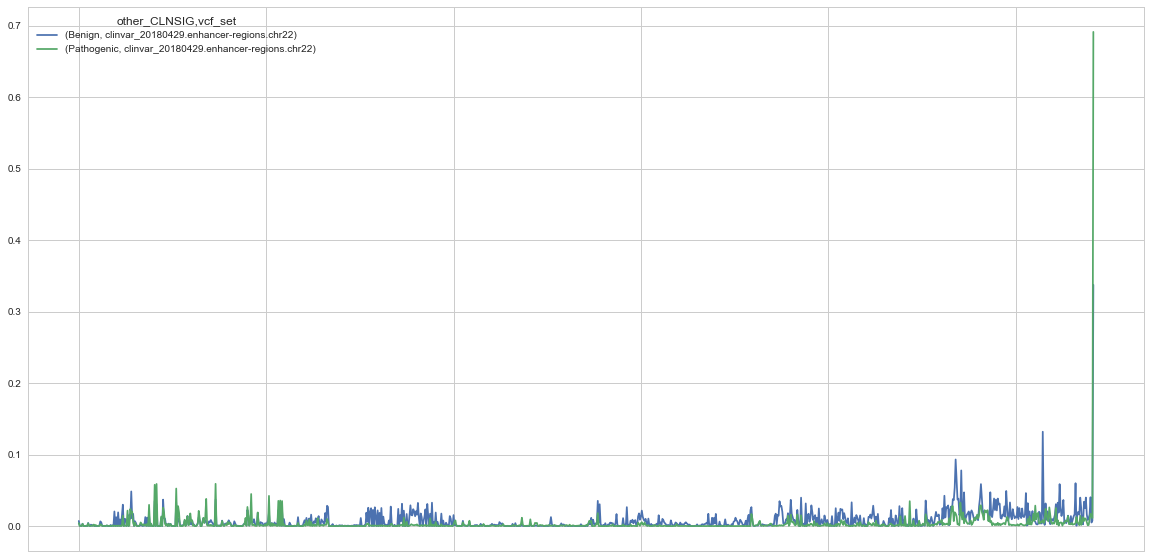

In [73]:
dfm_sub_max.plot(figsize=(20, 10))

In [ ]:
dfm_sub[dfm_sub.other_CLNSIG.isin(["Pathogenic", 'Benign'])].groupby(['other_CLNSIG', 'vcf_set']).max()

In [60]:
dfm_sub[~dfm_sub.other_CLNSIG.isnull()]

,vcf_set,other_CLNSIG,DeepSEA/variantEffects/diff/8988T_DNase_None,DeepSEA/variantEffects/diff/A549_ATF3_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_BCL3_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_BHLHE40_None,DeepSEA/variantEffects/diff/A549_CEBPB_None,DeepSEA/variantEffects/diff/A549_CREB1_DEX_100nM,DeepSEA/variantEffects/diff/A549_CTCF_DEX_100nM,DeepSEA/variantEffects/diff/A549_CTCF_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_CTCF_None/0,DeepSEA/variantEffects/diff/A549_CTCF_None/1,DeepSEA/variantEffects/diff/A549_DNase_None,DeepSEA/variantEffects/diff/A549_ELF1_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_ETS1_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_FOSL2_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_FOXA1_DEX_100nM,DeepSEA/variantEffects/diff/A549_GABP_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_GR_DEX_100nM,DeepSEA/variantEffects/diff/A549_GR_DEX_500pM,DeepSEA/variantEffects/diff/A549_GR_DEX_50nM,DeepSEA/variantEffects/diff/A549_GR_DEX_5nM,DeepSEA/variantEffects/diff/A549_Max_None,DeepSEA/variantEffects/diff/A549_NRSF_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_Pol2(phosphoS2)_None,DeepSEA/variantEffects/diff/A549_Pol2_DEX_100nM,DeepSEA/variantEffects/diff/A549_Pol2_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_Pol2_None,DeepSEA/variantEffects/diff/A549_Rad21_None,DeepSEA/variantEffects/diff/A549_SIX5_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_Sin3Ak-20_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_TAF1_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_TCF12_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_USF-1_DEX_100nM,DeepSEA/variantEffects/diff/A549_USF-1_EtOH_0.02pct/0,DeepSEA/variantEffects/diff/A549_USF-1_EtOH_0.02pct/1,DeepSEA/variantEffects/diff/A549_YY1_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_ZBTB33_EtOH_0.02pct,DeepSEA/variantEffects/diff/A549_p300_EtOH_0.02pct,DeepSEA/variantEffects/diff/AG04449_CTCF_None,DeepSEA/variantEffects/diff/AG04449_DNase_None,DeepSEA/variantEffects/diff/AG04450_CTCF_None,DeepSEA/variantEffects/diff/AG04450_DNase_None,DeepSEA/variantEffects/diff/AG09309_CTCF_None,DeepSEA/variantEffects/diff/AG09309_DNase_None,DeepSEA/variantEffects/diff/AG09319_CTCF_None,DeepSEA/variantEffects/diff/AG09319_DNase_None,DeepSEA/variantEffects/diff/AG10803_CTCF_None,DeepSEA/variantEffects/diff/AG10803_DNase_None,DeepSEA/variantEffects/diff/Adult_CD4_Th0_DNase_None,DeepSEA/variantEffects/diff/AoAF_CTCF_None,DeepSEA/variantEffects/diff/AoAF_DNase_None,DeepSEA/variantEffects/diff/AoSMC_DNase_None,DeepSEA/variantEffects/diff/BE2_C_CTCF_None,DeepSEA/variantEffects/diff/BE2_C_DNase_None,DeepSEA/variantEffects/diff/BJ_CTCF_None,DeepSEA/variantEffects/diff/BJ_DNase_None,DeepSEA/variantEffects/diff/CD20+_DNase_None,DeepSEA/variantEffects/diff/CD34+_Mobilized_DNase_None,DeepSEA/variantEffects/diff/CLL_DNase_None,DeepSEA/variantEffects/diff/CMK_DNase_None,DeepSEA/variantEffects/diff/Caco-2_CTCF_None,DeepSEA/variantEffects/diff/Caco-2_DNase_None,DeepSEA/variantEffects/diff/Chorion_DNase_None,DeepSEA/variantEffects/diff/Dnd41_CTCF_None,DeepSEA/variantEffects/diff/Dnd41_EZH2_None,DeepSEA/variantEffects/diff/ECC-1_CTCF_DMSO_0.02pct,DeepSEA/variantEffects/diff/ECC-1_ERalpha_BPA_100nM,DeepSEA/variantEffects/diff/ECC-1_ERalpha_Estradiol_10nM,DeepSEA/variantEffects/diff/ECC-1_ERalpha_Genistein_100nM,DeepSEA/variantEffects/diff/ECC-1_FOXA1_DMSO_0.02pct,DeepSEA/variantEffects/diff/ECC-1_GR_DEX_100nM,DeepSEA/variantEffects/diff/ECC-1_Pol2_DMSO_0.02pct,DeepSEA/variantEffects/diff/FibroP_DNase_None,DeepSEA/variantEffects/diff/Fibrobl_CTCF_None,DeepSEA/variantEffects/diff/Fibrobl_DNase_None,DeepSEA/variantEffects/diff/GM06990_CTCF_None,DeepSEA/variantEffects/diff/GM06990_DNase_None,DeepSEA/variantEffects/diff/GM08714_ZNF274_None,DeepSEA/variantEffects/diff/GM10847_NFKB_TNFa,DeepSEA/variantEffects/diff/GM10847_Pol2_None,DeepSEA/variantEffects/diff/GM12801_CTCF_None,DeepSEA/variantEffects/diff/GM12864_CTCF_None,DeepSEA/variantEffects/diff/GM12864_DNase_None,DeepSEA/variantEffects/diff/GM12865_CTCF_None,DeepSEA/

Text(34,0.5,'Variant')

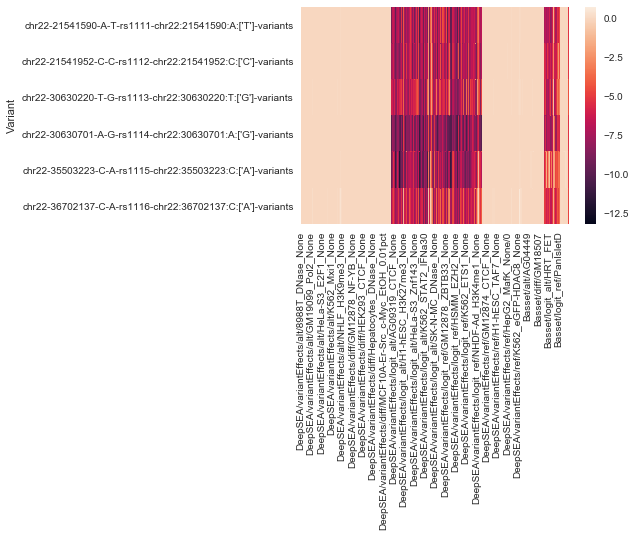

In [10]:
sns.heatmap(df)
plt.ylabel("Variant")

### Loading predictions from the hdf5 output

In [11]:
from kipoi.readers import HDF5Reader

List of entries:

In [14]:
f = "output/Basset/variants.h5"

In [15]:
r = HDF5Reader(f)
r.open()

In [16]:
r.ls()

[('/line_idx', <HDF5 dataset "line_idx": shape (6,), type "|O">),
 ('/preds/alt/8988T', <HDF5 dataset "8988T": shape (6,), type "<f4">),
 ('/preds/alt/A549', <HDF5 dataset "A549": shape (6,), type "<f4">),
 ('/preds/alt/ADRL_GLND_FET',
  <HDF5 dataset "ADRL_GLND_FET": shape (6,), type "<f4">),
 ('/preds/alt/AG04449', <HDF5 dataset "AG04449": shape (6,), type "<f4">),
 ('/preds/alt/AG04450', <HDF5 dataset "AG04450": shape (6,), type "<f4">),
 ('/preds/alt/AG09309', <HDF5 dataset "AG09309": shape (6,), type "<f4">),
 ('/preds/alt/AG09319', <HDF5 dataset "AG09319": shape (6,), type "<f4">),
 ('/preds/alt/AG10803', <HDF5 dataset "AG10803": shape (6,), type "<f4">),
 ('/preds/alt/AoAF', <HDF5 dataset "AoAF": shape (6,), type "<f4">),
 ('/preds/alt/AoSMC', <HDF5 dataset "AoSMC": shape (6,), type "<f4">),
 ('/preds/alt/BE2_C', <HDF5 dataset "BE2_C": shape (6,), type "<f4">),
 ('/preds/alt/BJ', <HDF5 dataset "BJ": shape (6,), type "<f4">),
 ('/preds/alt/BLD_CD14_PC',
  <HDF5 dataset "BLD_CD14_

In [17]:
# load the values
d = HDF5Reader.load(f, unflatten=False)

In [20]:
list(d.keys())[:5]

['/line_idx',
 '/preds/alt/8988T',
 '/preds/alt/A549',
 '/preds/alt/ADRL_GLND_FET',
 '/preds/alt/AG04449']

In [21]:
def df2index(df):
    return pd.MultiIndex.from_arrays([df.values[:,i] for i in range(df.shape[1])], names=list(df.columns))


def read_preds_h5(model, vcf_set, output_dir, scoring_fn='diff'):
    d = HDF5Reader.load("{}/{}/{}.h5".format(output_dir, model, vcf_set), unflatten=False)
    preds = d.pop(f"/preds/{scoring_fn}/{model}_prb")
    
    if preds.ndim == 1:
        preds = preds[:, np.newaxis]
    assert preds.ndim == 2  # this example works only with 2 dim output arrays
    
    metadata_table = pd.DataFrame(d)
    metadata_table.columns = metadata_table.columns.str.replace("^/", "")
    metadata_table['vcf_set'] = vcf_set
    metadata_table = metadata_table[merge_cols]  # re-order
    
    if preds.shape[1] > 1 and model != 'Basset':
        # TODO - remove
        descr = kipoi.get_model_descr(model)
        return pd.DataFrame(preds, 
                            columns=model + "/" + pd.Series(descr.schema.targets.column_labels),
                            index=df2index(metadata_table))
    else:
        return pd.DataFrame(preds, columns = model + "/" + pd.Series(np.arange(preds.shape[1]), dtype=str),
                            index=df2index(metadata_table))

In [22]:
df = pd.concat([read_preds_h5(m, 'variants', output_dir='output') for m in models], axis=1)

KeyError: '/preds/diff/DeepSEA/variantEffects_prb'

In [ ]:
df.head()